In [3]:
import numpy as np
import matplotlib.pyplot  as plt
from plant import *

In [4]:
plant_params = {
                'sigma': 20, # Coeficiente de proporcionalidade da corrente de tunelamento
                'work_fn':4.7, # Função trabalho
                'Vb':.5, # Tensão de polarização
                'offset': 5., # distancia do piezo com relação a menor altura
                'm': .1, # Massa do piezo
                'b_': 5, # Coeficiente de viscosidade
                'a': .95, # Coeficiente de pós-escoamento
                'ki': 90, # rigidez
                'd': 90, # Coeficiente do piezo m/V

                # Constantes para medir o deslocamento inerente à histerese
                'alpha': 1, 
                'beta': 0.8,
                'gamma': 0.2,
                'n': 2,}



def PID(Kp, Ki,  Kd, delta_T = 1e-3, MV_bar=0):
    # initialize stored data
    e_prev = 0
    delta_T = delta_T
    I = 0

    # initial control
    MV = MV_bar
    

    while True:
        
        # yield MV, wait for new t, PV, SP
        PV, SP = yield MV

        # PID calculations
        e = SP - PV

        P = Kp*e
        I = I + Ki*e*delta_T
        D = Kd*(e - e_prev)/delta_T

        MV = MV_bar + P + I + D

        # update stored data for next iteration
        e_prev = e


class PIDControlSTM:
    def __init__(self, params, dt = 1e-3, Kp=1, Ki=1, Kd=1):
    
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.MV_bar, _, _ = stm_sim(0, 0, np.zeros(3), dt, params) 

        self.dt = dt
        self.plant_params = params
        
        self.model = PID(self.Kp, self.Ki, self.Kd, self.dt, self.MV_bar)
        self.model.send(None) 
    

    
    def controller(self, perturbation, desired_out):

            u = 0
            results = []
            states = np.zeros(3)

            y_stm = np.zeros_like(perturbation)
            delta_z_list = np.zeros_like(perturbation)
            applied_input = np.zeros_like(perturbation)
            error = np.zeros_like(perturbation)

            for i, point in enumerate(perturbation):
                current, delta_z, states =  stm_sim(u, point, states, self.dt, self.plant_params)             
                y_stm[i] = current
                delta_z_list[i] = delta_z
                applied_input[i] = u
                error[i] = desired_out - current
                
                u = self.model.send([current, desired_out])

            return y_stm, delta_z_list, applied_input, error

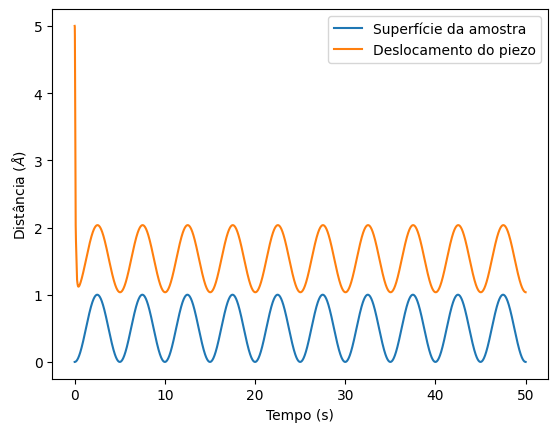

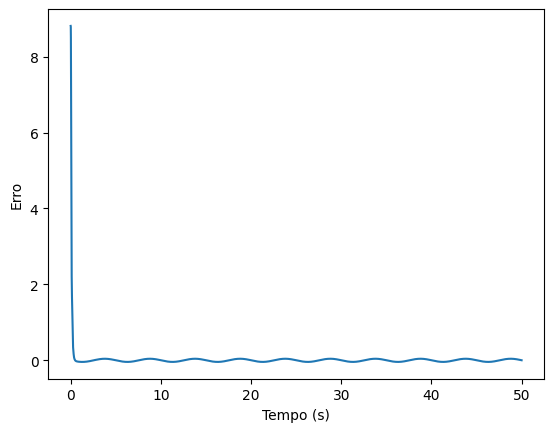

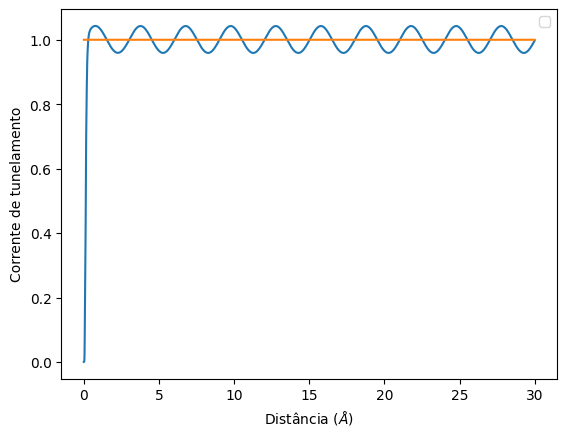

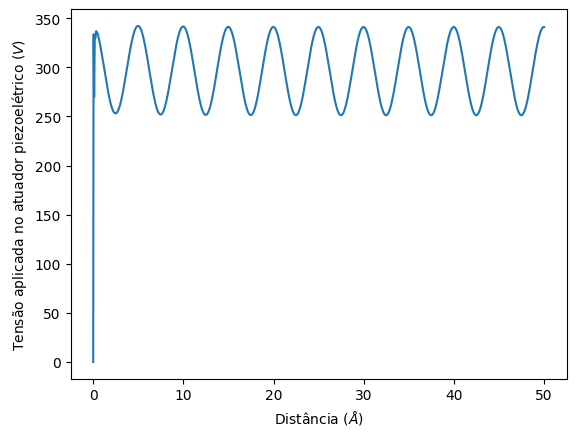

In [29]:

final = 50
dt = 1e-3
atom_radius = 3
n_atoms = 10
correction_constant = (atom_radius*n_atoms)/final
t = np.arange(0, final, dt)
w = np.pi*n_atoms/final
h = np.sin(w*t)**2



PID_model = PIDControlSTM(plant_params, Kp=1, Ki=15, Kd=0)
y_stm, delta_z_list, applied_input, error = PID_model.controller(h, np.log(1))


plt.ylabel("Distância ($\AA$)")
plt.xlabel("Tempo (s)")
plt.plot(t, h, t, h + delta_z_list)
plt.legend(["Superfície da amostra", "Deslocamento do piezo"])
plt.show()

plt.ylabel("Erro")
plt.xlabel("Tempo (s)")
plt.plot(t, error)
plt.show()

plt.ylabel("Corrente de tunelamento")
plt.xlabel("Distância ($\AA$)")
plt.legend(["Corrente de tunelamento do STM", "Corrente de tunelamento desejada"])
plt.plot(correction_constant*t, np.exp(y_stm), correction_constant*t, np.ones_like(t))
plt.show()




plt.ylabel("Tensão aplicada no atuador piezoelétrico ($V$)")
plt.xlabel("Distância ($\AA$)")
plt.plot(t, plant_params['d']*applied_input)
plt.show()

